In [ ]:
#Import package yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt
import tensorflow as tf
from keras.layers import GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2
from keras.layers import Bidirectional
from tensorflow.keras import layers
from keras.layers import Flatten

Upload File yang akan digunakan

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving curah hujan perhari.csv to curah hujan perhari.csv


In [ ]:
df = pd.read_csv('curah hujan perhari.csv', sep=';')
dataSize = len(df)
df.head()

,tanggal,curah hujan
0,01/01/2018,0.0
1,02/01/2018,0.6
2,03/01/2018,0.5
3,04/01/2018,20.0
4,05/01/2018,0.4


Cek data hilang

In [ ]:
df.isnull().sum()

tanggal         0
curah hujan    96
dtype: int64

Plot Data dengan Data Hilang

Text(0, 0.5, 'Jumlah')

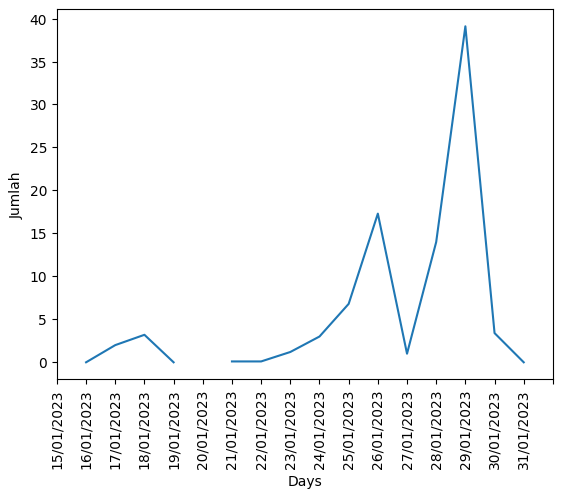

In [ ]:
linspace = [0]
while linspace[-1] < 17-1:
    linspace.append(linspace[-1]+1)
linspace.append(17)

plt.plot(df['tanggal'][1840:1857], df['curah hujan'][1840:1857])
plt.xticks(linspace, rotation='vertical')
plt.xlabel('Days')
plt.ylabel('Jumlah')

Proses Imputasi

In [ ]:
df['curah hujan'] = df['curah hujan'].interpolate(option='spline')

In [ ]:
df.describe()

,curah hujan
count,1964.000000
mean,9.126426
std,16.033353
min,0.000000
25%,0.000000
50%,1.800000
75%,11.900000
max,164.100000


Plot Data Setelah Proses Imputasi

Text(0, 0.5, 'Jumlah')

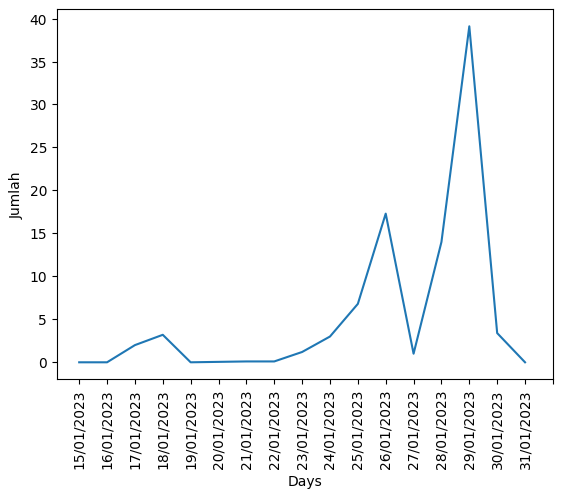

In [ ]:
linspace = [0]
while linspace[-1] < 17-1:
    linspace.append(linspace[-1]+1)
linspace.append(17)

plt.plot(df['tanggal'][1840:1857], df['curah hujan'][1840:1857])
plt.xticks(linspace, rotation='vertical')
plt.xlabel('Days')
plt.ylabel('Jumlah')

Plot Data Curah Hujan Harian Kabupaten Bogor

Text(0, 0.5, 'Jumlah')

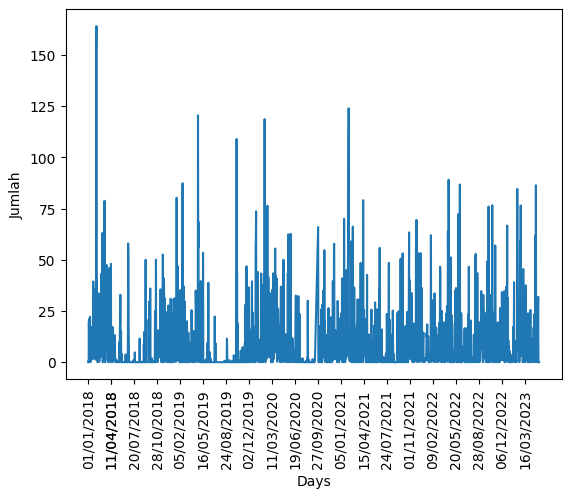

In [ ]:
linspace = [0]
while linspace[-1] < 1964-100:
    linspace.append(linspace[-1]+100)
linspace.append(100)

plt.plot(df['tanggal'], df['curah hujan'])
plt.xticks(linspace, rotation='vertical')
plt.xlabel('Days')
plt.ylabel('Jumlah')

In [ ]:
train_split = .8
train_size = int(train_split * dataSize)
trainData = df[:train_size]
valData = df[train_size:]
print('Train data size: ', trainData.shape)
print('Val data size: ', valData.shape)

In [ ]:
trainData

In [ ]:
plt.subplots(figsize = (25,8))
sns.lineplot(x="tanggal", y="curah hujan",
             data=trainData, marker='.', label='Data Training')
sns.lineplot(x="tanggal", y="curah hujan",
             data=valData, marker='.', label='Data Testing')
plt.title("Pembagian Data Training dan Testing", fontsize = 20)
plt.legend(loc='upper left', prop={'size': 16})

In [ ]:
dataMat = df['curah hujan'].values.reshape(dataSize,1)
dataMat.shape

(1964, 1)

In [ ]:
#Scaling data menjadi nilai antara 0 dan 1
scaler = MinMaxScaler(feature_range=(0,1))
scaledDataMat = scaler.fit_transform(dataMat)

In [ ]:
#Perbandingan nilai asli dengan nilai hasil scaling
df_scaled = pd.DataFrame(columns=['tanggal', 'Curah hujan', 'Curah hujan Normal'])
df_scaled['tanggal'] = df['tanggal']
df_scaled['Curah hujan'] = df['curah hujan']
df_scaled['Curah hujan Normal'] = scaledDataMat
df_scaled

In [ ]:
#Pembagian data train dan test
train_split = .8
train_size = int(train_split * dataSize)
trainData = scaledDataMat[:train_size]
valData = scaledDataMat[train_size:]
print('Train data size: ', trainData.shape)
print('Val data size: ', valData.shape)

Train data size:  (1571, 1)
Val data size:  (393, 1)


In [ ]:
def createDataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		dataX.append(dataset[i:(i+time_step)])
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [ ]:
n_past = 7 # h = 7,14, dan 28 forecast ahead (input1) #
X_train,y_train = createDataset(trainData, time_step=n_past)
X_val,y_val = createDataset(valData, time_step=n_past)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1543, 28, 1) (1543, 1)
(365, 28, 1) (365, 1)


In [ ]:
tf.random.set_seed(1234)

In [ ]:
from keras.layers import LSTM
from keras.layers import Bidirectional
from tensorflow.keras import layers
from keras.layers import Flatten

MODEL VANILLA LSTM

In [ ]:
#Model LSTM
tf.keras.backend.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(32,activation='relu',recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),return_sequences=False, input_shape=X_train[0].shape)) # activation = relu ( input 3)#
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_lstm.compile(loss='mae',optimizer='adam', metrics=['mse','mae'])  # opt=adm (input 4)#
history_lstm = model_lstm.fit(X_train,y_train,validation_data=(X_val,y_val), batch_size=16, epochs=1000, callbacks=[callback]) # batch_size, Input =5 #

Epoch 1/1000
98/98 [==============================] - 3s 9ms/step - loss: 0.4890 - mse: 0.0104 - mae: 0.0496 - val_loss: 0.3720 - val_mse: 0.0106 - val_mae: 0.0581
Epoch 2/1000
98/98 [==============================] - 1s 6ms/step - loss: 0.3105 - mse: 0.0104 - mae: 0.0496 - val_loss: 0.2784 - val_mse: 0.0105 - val_mae: 0.0581
Epoch 3/1000
98/98 [==============================] - 1s 6ms/step - loss: 0.2435 - mse: 0.0103 - mae: 0.0496 - val_loss: 0.2282 - val_mse: 0.0105 - val_mae: 0.0580
Epoch 4/1000
98/98 [==============================] - 1s 7ms/step - loss: 0.2003 - mse: 0.0103 - mae: 0.0492 - val_loss: 0.1912 - val_mse: 0.0106 - val_mae: 0.0581
Epoch 5/1000
98/98 [==============================] - 1s 6ms/step - loss: 0.1671 - mse: 0.0102 - mae: 0.0492 - val_loss: 0.1612 - val_mse: 0.0103 - val_mae: 0.0579
Epoch 6/1000
98/98 [==============================] - 1s 6ms/step - loss: 0.1401 - mse: 0.0101 - mae: 0.0492 - val_loss: 0.1370 - val_mse: 0.0101 - val_mae: 0.0579
Epoch 7/1000
98/

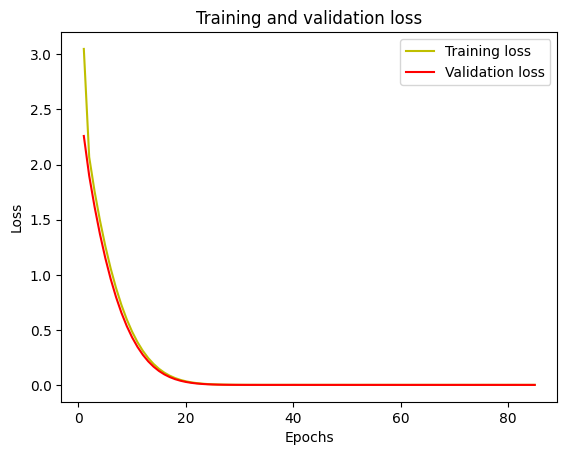

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_lstm.evaluate(X_train,y_train)

49/49 [==============================] - 0s 4ms/step - loss: 0.0489 - mse: 0.0097 - mae: 0.0488


[0.04885134845972061, 0.00969014409929514, 0.048819247633218765]

In [ ]:
#Evaluasi model
model_lstm.evaluate(X_val,y_val)

13/13 [==============================] - 0s 3ms/step - loss: 0.0580 - mse: 0.0102 - mae: 0.0580


[0.05798943340778351, 0.010235297493636608, 0.05795732140541077]

In [ ]:
y_train_hat = scaler.inverse_transform(model_lstm.predict(X_train))
y_val_hat = scaler.inverse_transform(model_lstm.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

13/13 [==============================] - 0s 2ms/step


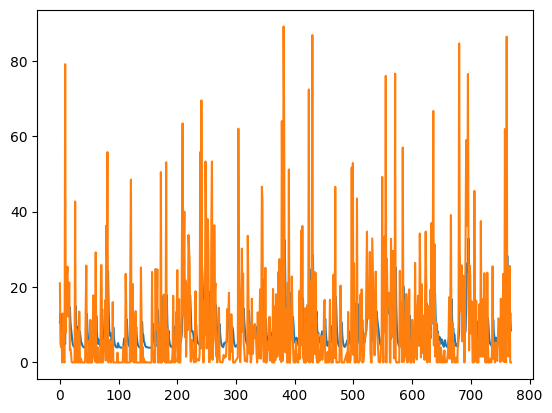

In [ ]:
plt.plot(y_val_hat)
plt.plot(yval)

Text(0, 0.5, 'Curah Hujan')

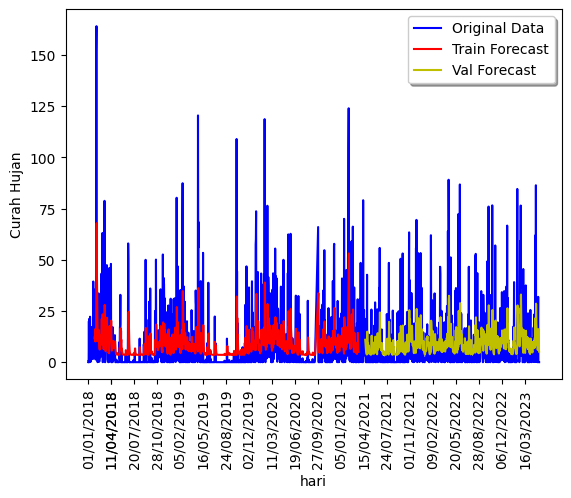

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
from sklearn.metrics import mean_squared_error
mse_lstm_train = mean_squared_error(ytrain, y_train_hat)
rmse_lstm_train=np.sqrt(mse_lstm_train)
print('Nilai RMSE train: %.3f' % rmse_lstm_train)
mse_lstm_test = mean_squared_error(yval, y_val_hat)
rmse_lstm_test=np.sqrt(mse_lstm_test)
print('Nilai RMSE test: %.3f' % rmse_lstm_test)

Nilai RMSE train: 16.139
Nilai RMSE test: 16.460


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_lstm_train = mean_absolute_error(ytrain,y_train_hat)
mae_lstm_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_lstm_train)
print('Nilai MAE test: %.3f' % mae_lstm_test)

Nilai MAE train: 8.011
Nilai MAE test: 9.511


In [ ]:
# generate the multi-step forecasts
def forecasts(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_lstm.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

In [ ]:
lstm_forecast=forecasts(n_past=0, n_future=14)

1/1 [==============================] - 0s 23ms/step


In [ ]:
lstm_forecast

array([9.003423 , 9.246869 , 9.408665 , 9.516224 , 9.587443 , 9.634852 ,
       9.6664915, 9.686865 , 9.700989 , 9.710425 , 9.715795 , 9.720157 ,
       9.72297  , 9.725012 ], dtype=float32)

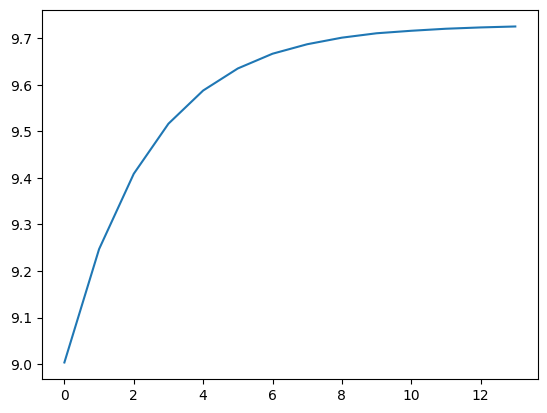

In [ ]:
plt.plot(lstm_forecast)

In [ ]:
tf.random.set_seed(1234)

MODEL STACKED LSTM

In [ ]:
##model Stacked LSTM
tf.keras.backend.clear_session()
model_Slstm = Sequential()
model_Slstm.add(LSTM(256,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', return_sequences=True, input_shape=X_train[0].shape))
model_Slstm.add(Dropout(0.2))
model_Slstm.add(LSTM(256,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu',return_sequences=False))
model_Slstm.add(Dropout(0.2))
model_Slstm.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_Slstm.compile(loss='mae',optimizer='adam',metrics=['mae','mse'])
history_Slstm = model_Slstm.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=16,epochs=500, callbacks=[callback])

Epoch 1/500
97/97 [==============================] - 23s 205ms/step - loss: 5.6936 - mae: 0.0507 - mse: 0.0110 - val_loss: 4.2739 - val_mae: 0.0597 - val_mse: 0.0111
Epoch 2/500
97/97 [==============================] - 19s 195ms/step - loss: 3.8422 - mae: 0.0505 - mse: 0.0109 - val_loss: 3.4521 - val_mae: 0.0599 - val_mse: 0.0112
Epoch 3/500
97/97 [==============================] - 19s 200ms/step - loss: 3.0997 - mae: 0.0503 - mse: 0.0107 - val_loss: 2.7750 - val_mae: 0.0601 - val_mse: 0.0114
Epoch 4/500
97/97 [==============================] - 18s 189ms/step - loss: 2.4766 - mae: 0.0501 - mse: 0.0107 - val_loss: 2.2053 - val_mae: 0.0592 - val_mse: 0.0105
Epoch 5/500
97/97 [==============================] - 19s 195ms/step - loss: 1.9563 - mae: 0.0501 - mse: 0.0106 - val_loss: 1.7334 - val_mae: 0.0596 - val_mse: 0.0111
Epoch 6/500
97/97 [==============================] - 19s 196ms/step - loss: 1.5264 - mae: 0.0498 - mse: 0.0106 - val_loss: 1.3457 - val_mae: 0.0592 - val_mse: 0.0106
Epoc

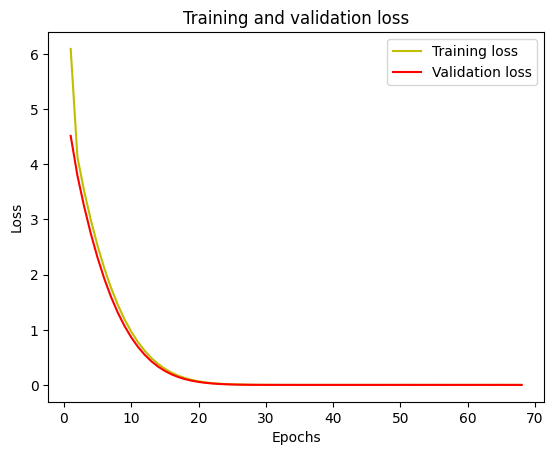

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_Slstm.history['loss']
val_loss = history_Slstm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_Slstm.evaluate(X_train,y_train)

49/49 [==============================] - 4s 77ms/step - loss: 0.0489 - mae: 0.0488 - mse: 0.0098


[0.04894113540649414, 0.04876302555203438, 0.009773245081305504]

In [ ]:
#Evaluasi model
model_Slstm.evaluate(X_val,y_val)

12/12 [==============================] - 1s 64ms/step - loss: 0.0586 - mae: 0.0584 - mse: 0.0102


[0.058627016842365265, 0.058448899537324905, 0.010221844539046288]

In [ ]:
y_train_hat = scaler.inverse_transform(model_Slstm.predict(X_train))
y_val_hat = scaler.inverse_transform(model_Slstm.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

12/12 [==============================] - 1s 64ms/step


Text(0, 0.5, 'Curah Hujan')

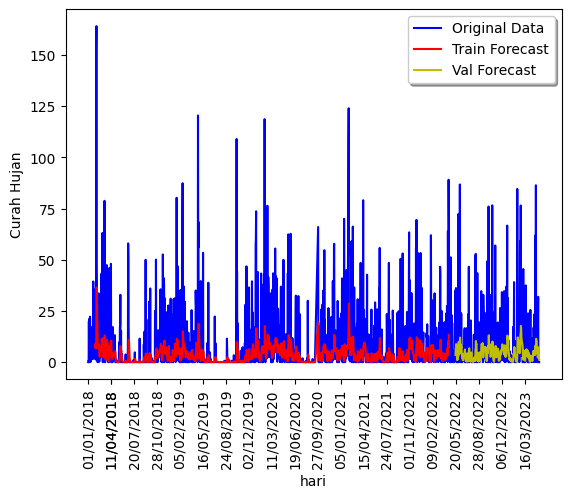

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
from sklearn.metrics import mean_squared_error
mse_Slstm_train = mean_squared_error(ytrain, y_train_hat)
rmse_Slstm_train=np.sqrt(mse_Slstm_train)
print('Nilai RMSE train: %.3f' % rmse_Slstm_train)
mse_Slstm_test = mean_squared_error(yval, y_val_hat)
rmse_Slstm_test=np.sqrt(mse_Slstm_test)
print('Nilai RMSE test: %.3f' % rmse_Slstm_test)

Nilai RMSE train: 15.636
Nilai RMSE test: 14.457


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_Slstm_train = mean_absolute_error(ytrain,y_train_hat)
mae_Slstm_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_Slstm_train)
print('Nilai MAE test: %.3f' % mae_Slstm_test)

Nilai MAE train: 8.043
Nilai MAE test: 9.465


In [ ]:
# generate the multi-step forecasts
def forecast(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_Slstm.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

Slstm_forecast=forecast(n_past=0,n_future=28)
Slstm_forecast

1/1 [==============================] - 0s 47ms/step


array([0.6359818 , 0.35632017, 0.22203912, 0.15778527, 0.12705798,
       0.11236206, 0.10533222, 0.10196934, 0.10036068, 0.09959137,
       0.0992236 , 0.09904774, 0.09896379, 0.09892373, 0.09890451,
       0.09889541, 0.09889107, 0.09888902, 0.09888803, 0.09888756,
       0.09888735, 0.09888726, 0.09888721, 0.09888718, 0.09888715,
       0.09888715, 0.09888715, 0.09888715], dtype=float32)

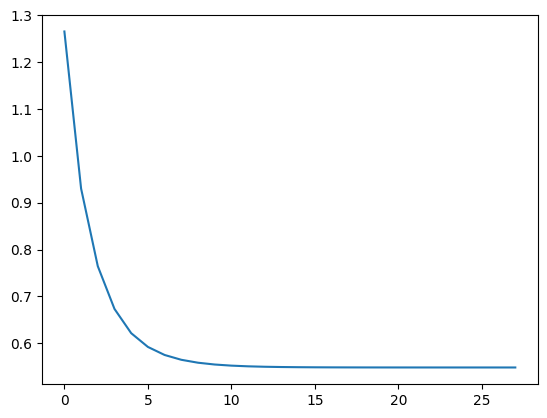

In [ ]:
plt.plot(Slstm_forecast)

MODEL BIDIRECTIONAL LSTM

In [ ]:
#model Bilstm
tf.keras.backend.clear_session()
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(32,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', input_shape=X_train[0].shape)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_bilstm.compile(loss='mae',optimizer='adam',metrics=['mae','mse'])
history_bilstm = model_bilstm.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=16, epochs=500, callbacks=[callback])

Epoch 1/500
98/98 [==============================] - 5s 14ms/step - loss: 0.9325 - mae: 0.0519 - mse: 0.0115 - val_loss: 0.6885 - val_mae: 0.0587 - val_mse: 0.0107
Epoch 2/500
98/98 [==============================] - 1s 9ms/step - loss: 0.5735 - mae: 0.0504 - mse: 0.0107 - val_loss: 0.4996 - val_mae: 0.0585 - val_mse: 0.0107
Epoch 3/500
98/98 [==============================] - 1s 9ms/step - loss: 0.4381 - mae: 0.0501 - mse: 0.0106 - val_loss: 0.3988 - val_mae: 0.0585 - val_mse: 0.0108
Epoch 4/500
98/98 [==============================] - 1s 8ms/step - loss: 0.3521 - mae: 0.0498 - mse: 0.0106 - val_loss: 0.3248 - val_mae: 0.0586 - val_mse: 0.0109
Epoch 5/500
98/98 [==============================] - 1s 8ms/step - loss: 0.2854 - mae: 0.0496 - mse: 0.0105 - val_loss: 0.2648 - val_mae: 0.0582 - val_mse: 0.0106
Epoch 6/500
98/98 [==============================] - 1s 8ms/step - loss: 0.2315 - mae: 0.0497 - mse: 0.0106 - val_loss: 0.2165 - val_mae: 0.0583 - val_mse: 0.0108
Epoch 7/500
98/98 [==

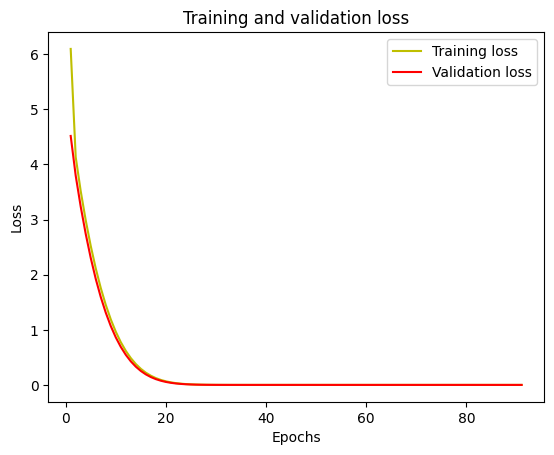

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_bilstm.history['loss']
val_loss = history_bilstm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_train_hat = scaler.inverse_transform(model_bilstm.predict(X_train))
y_val_hat = scaler.inverse_transform(model_bilstm.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

13/13 [==============================] - 0s 5ms/step


Text(0, 0.5, 'Curah Hujan')

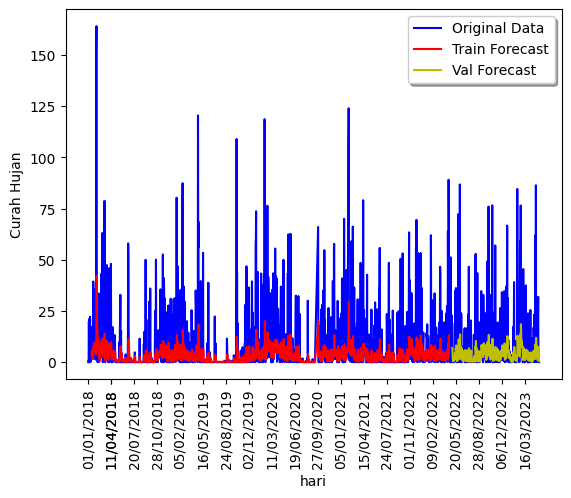

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
model_bilstm.evaluate(X_train,y_train)

49/49 [==============================] - 0s 5ms/step - loss: 0.0494 - mae: 0.0493 - mse: 0.0096


[0.04936622828245163, 0.04934241622686386, 0.009590303525328636]

In [ ]:
#Evaluasi model
model_bilstm.evaluate(X_val,y_val)

13/13 [==============================] - 0s 5ms/step - loss: 0.0580 - mae: 0.0580 - mse: 0.0101


[0.05800668150186539, 0.05798286944627762, 0.010114357806742191]

In [ ]:
from sklearn.metrics import mean_squared_error
mse_bilstm_train = mean_squared_error(ytrain, y_train_hat)
rmse_bilstm_train=np.sqrt(mse_bilstm_train)
print('Nilai RMSE train: %.3f' % rmse_bilstm_train)
mse_bilstm_test = mean_squared_error(yval, y_val_hat)
rmse_bilstm_test=np.sqrt(mse_bilstm_test)
print('Nilai RMSE test: %.3f' % rmse_bilstm_test)

Nilai RMSE train: 15.534
Nilai RMSE test: 14.551


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_bilstm_train = mean_absolute_error(ytrain,y_train_hat)
mae_bilstm_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_bilstm_train)
print('Nilai MAE test: %.3f' % mae_bilstm_test)

Nilai MAE train: 8.097
Nilai MAE test: 9.515


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape=mean_absolute_percentage_error(yval,y_val_hat)
mape=mape*100
mape

113.76788020000255

In [ ]:
# generate the multi-step forecasts
def forecast(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_bilstm.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

bilstm_forecast=forecast(n_past=0,n_future=28)
bilstm_forecast

1/1 [==============================] - 0s 26ms/step


array([ 4.059316 ,  5.1267567,  7.6383986,  9.275539 ,  8.908275 ,
        9.830551 , 10.668068 ,  9.399629 ,  9.367299 , 10.487769 ,
        9.528572 ,  7.180193 ,  8.984338 , 10.009855 , 10.3028965,
       11.06429  , 12.272967 , 10.203392 , 11.224598 , 11.703897 ,
       11.906725 , 12.140109 , 11.157351 , 12.149895 , 12.352391 ,
       13.567945 , 13.173526 , 12.600675 ], dtype=float32)

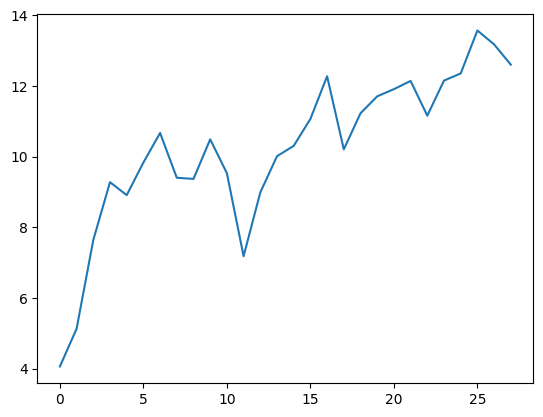

In [ ]:
plt.plot(bilstm_forecast)

In [ ]:
tf.random.set_seed(1234)

MODEL STACKED BIDIRECTIONAL LSTM

In [ ]:
#model Stacked Bilstm
tf.keras.backend.clear_session()
model_Sbilstm = Sequential()
model_Sbilstm.add(Bidirectional(LSTM(32,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             activation='relu', return_sequences=True, input_shape=X_train[0].shape)))
model_Sbilstm.add(Dropout(0.2))
model_Sbilstm.add(Bidirectional(LSTM(32,recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                             return_sequences=False,activation='relu')))
model_Sbilstm.add(Dropout(0.2))
model_Sbilstm.add(Dense(1))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
model_Sbilstm.compile(loss='mae',optimizer='adam', metrics=['mse','mae'])
history_Sbilstm = model_Sbilstm.fit(X_train,y_train,validation_data=(X_val,y_val),batch_size=16, epochs=500, callbacks=[callback])

Epoch 1/500
98/98 [==============================] - 9s 26ms/step - loss: 1.8092 - mse: 0.0112 - mae: 0.0512 - val_loss: 1.3171 - val_mse: 0.0116 - val_mae: 0.0602
Epoch 2/500
98/98 [==============================] - 3s 26ms/step - loss: 1.0949 - mse: 0.0105 - mae: 0.0500 - val_loss: 0.9405 - val_mse: 0.0108 - val_mae: 0.0586
Epoch 3/500
98/98 [==============================] - 2s 21ms/step - loss: 0.8258 - mse: 0.0105 - mae: 0.0499 - val_loss: 0.7391 - val_mse: 0.0108 - val_mae: 0.0584
Epoch 4/500
98/98 [==============================] - 2s 18ms/step - loss: 0.6543 - mse: 0.0105 - mae: 0.0498 - val_loss: 0.5904 - val_mse: 0.0105 - val_mae: 0.0581
Epoch 5/500
98/98 [==============================] - 2s 18ms/step - loss: 0.5207 - mse: 0.0103 - mae: 0.0492 - val_loss: 0.4710 - val_mse: 0.0103 - val_mae: 0.0579
Epoch 6/500
98/98 [==============================] - 2s 25ms/step - loss: 0.4129 - mse: 0.0102 - mae: 0.0492 - val_loss: 0.3746 - val_mse: 0.0107 - val_mae: 0.0583
Epoch 7/500
98/9

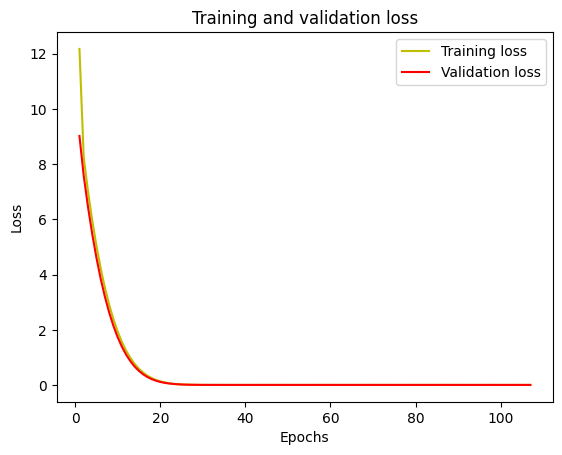

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_Sbilstm.history['loss']
val_loss = history_Sbilstm.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_Sbilstm.evaluate(X_train,y_train)

49/49 [==============================] - 0s 8ms/step - loss: 0.0486 - mse: 0.0095 - mae: 0.0485


[0.04863904416561127, 0.009467039257287979, 0.04852750897407532]

In [ ]:
#Evaluasi model
model_Sbilstm.evaluate(X_val,y_val)

13/13 [==============================] - 0s 9ms/step - loss: 0.0576 - mse: 0.0099 - mae: 0.0575


[0.05762526020407677, 0.009885657578706741, 0.05751373991370201]

In [ ]:
y_train_hat = scaler.inverse_transform(model_Sbilstm.predict(X_train))
y_val_hat = scaler.inverse_transform(model_Sbilstm.predict(X_val))
ytrain = scaler.inverse_transform(y_train)
yval = scaler.inverse_transform(y_val)

13/13 [==============================] - 0s 6ms/step


Text(0, 0.5, 'Curah Hujan')

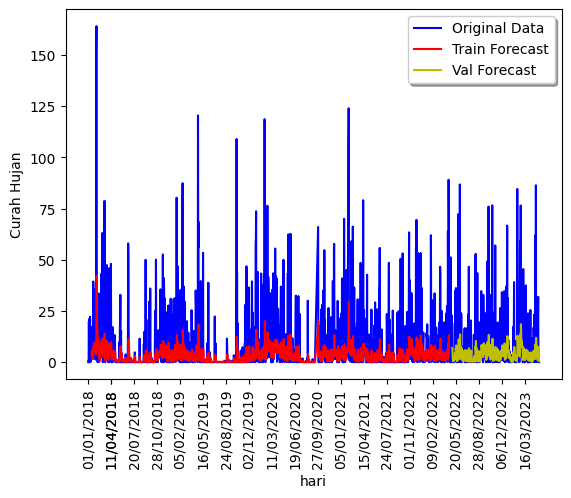

In [ ]:
train_shift = n_past
test_shift = train_shift + len(y_train_hat) + n_past


plt.plot(df['tanggal'], df['curah hujan'], color='b', label="Original Data")
plt.plot(df['tanggal'][train_shift: test_shift-n_past], y_train_hat, color='r', label="Train Forecast")
plt.plot(df['tanggal'][test_shift:], y_val_hat, color='y', label="Val Forecast")
plt.legend(loc='best', shadow=True)

plt.xticks(linspace, rotation='vertical')
plt.xlabel('hari')
plt.ylabel('Curah Hujan')

In [ ]:
from sklearn.metrics import mean_squared_error
mse_Sbilstm_train = mean_squared_error(ytrain, y_train_hat)
rmse_Sbilstm_train=np.sqrt(mse_Sbilstm_train)
print('Nilai RMSE train: %.3f' % rmse_Sbilstm_train)
mse_Sbilstm_test = mean_squared_error(yval, y_val_hat)
rmse_Sbilstm_test=np.sqrt(mse_Sbilstm_test)
print('Nilai RMSE test: %.3f' % rmse_Sbilstm_test)

Nilai RMSE train: 15.383
Nilai RMSE test: 14.579


In [ ]:
from sklearn.metrics import mean_absolute_error
mae_Sbilstm_train = mean_absolute_error(ytrain,y_train_hat)
mae_Sbilstm_test = mean_absolute_error(yval,y_val_hat)
print('Nilai MAE train: %.3f' % mae_Sbilstm_train)
print('Nilai MAE test: %.3f' % mae_Sbilstm_test)

Nilai MAE train: 7.963
Nilai MAE test: 9.438


In [ ]:
# generate the multi-step forecasts
def forecast(n_past, n_future):

    x_past = X_val[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y_val[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        x_past = np.append(x_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model_Sbilstm.predict(x_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])

    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

Sbilstm_forecast=forecast(n_past=0,n_future=7)
Sbilstm_forecast

1/1 [==============================] - 0s 42ms/step


array([ 9.275712, 10.503481, 10.980982, 11.457291, 11.730136, 11.653479,
       11.711149], dtype=float32)

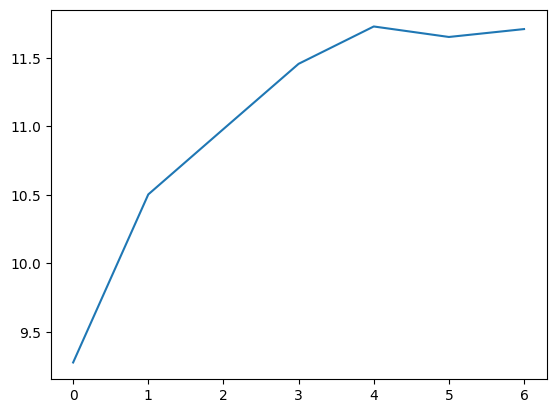

In [ ]:
plt.plot(Sbilstm_forecast)

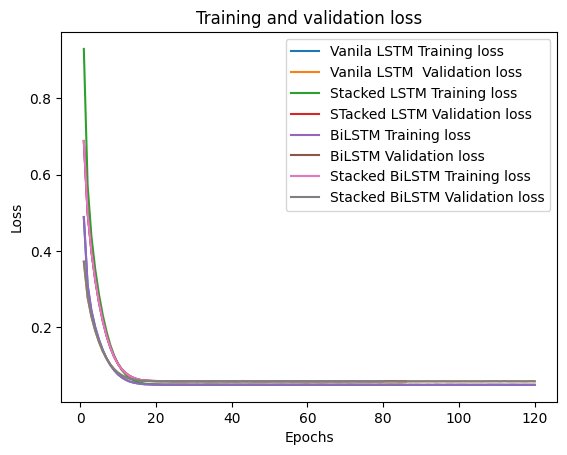

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss_vanila = history_lstm.history['loss']
val_loss_vanila = history_lstm.history['val_loss']
loss_stacked = history_Slstm.history['loss']
val_loss_stacked = history_Slstm.history['val_loss']
loss_bilstm = history_lstm.history['loss']
val_loss_bilstm =history_bilstm.history['val_loss']
loss_stacked_bilstm = history_bilstm.history['val_loss']
val_loss_stacked_bilstm = history_lstm.history['val_loss']
epochs_loss_vanila = range(1, len(loss_vanila) + 1)
epochs_loss_stacked = range(1, len(loss_stacked) + 1)
epochs_loss_bilstm = range(1, len(loss_bilstm) + 1)
epochs_loss_stacked_bilstm = range(1, len(loss_stacked_bilstm) + 1)
epochs_val_loss_vanila = range(1, len(val_loss_vanila) + 1)
epochs_val_loss_stacked = range(1, len(val_loss_stacked) + 1)
epochs_val_loss_bilstm = range(1, len(val_loss_bilstm) + 1)
epochs_val_loss_stacked_bilstm = range(1, len(val_loss_stacked_bilstm) + 1)
plt.plot(epochs_loss_vanila, loss_vanila, label='Vanila LSTM Training loss')
plt.plot(epochs_val_loss_vanila, val_loss_vanila, label='Vanila LSTM  Validation loss')
plt.plot(epochs_loss_stacked, loss_stacked, label='Stacked LSTM Training loss')
plt.plot(epochs_val_loss_stacked, val_loss_stacked, label='STacked LSTM Validation loss')
plt.plot(epochs_loss_bilstm, loss_bilstm, label='BiLSTM Training loss')
plt.plot(epochs_val_loss_bilstm, val_loss_bilstm, label='BiLSTM Validation loss')
plt.plot(epochs_loss_stacked_bilstm, loss_stacked_bilstm, label='Stacked BiLSTM Training loss')
plt.plot(epochs_val_loss_stacked_bilstm, val_loss_stacked_bilstm, label='Stacked BiLSTM Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NYOBA GRID SEARCH DARI GITUHUB INI LINKNYA https://github.com/akmuthun/Time-Series-Neural-Network-Grid-Search/blob/master/Multi%20Step%20Forecasting-MLP%20NN-Grid%20Search.ipynb

In [ ]:
#from math import sqrt
#from numpy import array
#from numpy import mean
#from pandas import DataFrame
#from pandas import concat
#from pandas import read_csv
#from sklearn.metrics import mean_squared_error


In [ ]:
#read time series dataset assume only one column = "univariate"
#dataset = scaledDataMat

In [ ]:
# split a univariate dataset into train/test sets
#def train_test_split(data, n_test):
#	return data[:-n_test], data[-n_test:]
# n_in = n_input = width of the sliding window which the number of input time steps in one row
# of the training data. We can decide the value of "n_input"
# in the main code when we specify configurations.


In [ ]:
# transform list into supervised learning format
#def series_to_supervised(data, n_in, n_out=1):
#	df = DataFrame(data)
#	cols = list()
	# input sequence (t-n, ... t-1)
#	for i in range(n_in, 0, -1):
#		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
#	for i in range(0, n_out):
#		cols.append(df.shift(-i))
	# put it all together
#	agg = concat(cols, axis=1)
	# drop rows with NaN values
#	agg.dropna(inplace=True)
#	return agg.values


In [ ]:
# root mean squared error or rmse
#def measure_rmse(actual, predicted):
#	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
#def difference(data, order):
#	return [data[i] - data[i - order] for i in range(order, len(data))]


In [ ]:
# fit a model
#def model_fit(train, config, num_step):
	# unpack config
#	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
#	if n_diff > 0:
#		train = difference(train, n_diff)
	# transform series into supervised format
#	data = series_to_supervised(train, n_in=n_input, n_out=num_step)#####################
	# separate inputs and outputs
#	train_x, train_y = data[:, :-num_step], data[:, -num_step:] ################
	# reshape input data into [samples, timesteps, features]
#	n_features = 1 #if it is multivariate then this should be changed acccordingly
#	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
#	model = tf.keras.Sequential([
#	tf.keras.layers.LSTM(n_nodes, activation='relu',recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=(n_input, n_features)),
#	tf.keras.layers.Dense(num_step)])###############
#	model.compile(loss='mse', optimizer='adam')
	# fit model
#	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
#	return model

In [ ]:
# forecast with the fit model
#def model_predict(model, history, config):
	# unpack config
#	n_input, _, _, _, n_diff = config
	# prepare data
#	correction = 0.0
#	if n_diff > 0:
#		correction = history[-n_diff]
#		history = difference(history, n_diff)
	# reshape sample into [samples, timesteps, features]
#	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
#	yhat = model.predict(x_input, verbose=0)
#	return correction + yhat[0]

In [ ]:
# walk-forward validation for univariate data
#def walk_forward_validation(data, n_test, cfg, num_step):###########
#	error_collection=list()################
	# split dataset
#	train, test = train_test_split(data, n_test)
	# fit model
#	model = model_fit(train, cfg, num_step)##############
	# seed history with training dataset
#	history = [x for x in train]
	# step over each time-step in the test set
#	for i in range(len(test)+1-num_step):############
		# fit model and make forecast for history
#		yhat = model_predict(model, history, cfg)
#		err = measure_rmse(test[i:i+num_step], yhat)#############
#		error_collection.append(err)
		# store forecast in list of predictions
		# add actual observation to history for the next loop
#		history.append(test[i])
	# estimate prediction error
#	error = mean(error_collection)######
	#print(' > %.3f' % error)
#	return error

In [ ]:
# score a model, return None on failure
#def repeat_evaluate(data, config, n_test, num_step, n_repeats=5):############
	# convert config to a key
#	key = str(config)
	# fit and evaluate the model n times
#	scores = [walk_forward_validation(data, n_test, config, num_step) for _ in range(n_repeats)]##########
	# summarize score
#	result = mean(scores)

#	return (result, config)#######


In [ ]:
# grid search configs
#def grid_search(data, cfg_list, n_test, num_step):#########
	# evaluate configs
#	scores = [repeat_evaluate(data, cfg, n_test, num_step) for cfg in cfg_list]#########
	# sort configs by error, asc
#	scores.sort()##########
#	return scores

In [ ]:
## create a list of configs to try
#def model_configs():
	# define scope of configs
#	n_input = [14]
#	n_nodes = [5,6,7,8,9,10,16,32,64,128]
#	n_epochs = [100]
#	n_batch = [16,32,64]
#	n_diff = [0]
	# create configs
#	configs = list()
#	for i in n_input:
#		for j in n_nodes:
#			for k in n_epochs:
#				for l in n_batch:
#					for m in n_diff:
#						cfg = [i, j, k, l, m]
#						configs.append(cfg)
#	print('Total configs: %d' % len(configs))
#	return configs

In [ ]:
#location_counter = 0
#n_test = 5 # keep this fixed
#data = dataset
#step_list = []
#location_list = []
#cfg_list = []
#error_list = []
#window_length_list = []
#nodes_list = []
#epochs_list = []
#batch_size_list = []
#diff_list =[]

#for num in [3]:# number of steps to forecast, this can be any number between 1 and 5
#  num_step = num
#  cfg_list = model_configs()
#  scores = grid_search(data, cfg_list, n_test, num_step)
#  print('done for the step: %d' % num_step)
  # list top 3 configs
#  error, cfg = scores[0]
#  print(cfg, error)
#  window_length_list.append(cfg[0])
#  nodes_list.append(cfg[1])
#  epochs_list.append(cfg[2])
#  batch_size_list.append(cfg[3])
#  diff_list.append(cfg[4])
#  error_list.append(error)
#  step_list.append(num_step)


In [ ]:
#collection = DataFrame()
#collection['Predict Step'] = step_list
#collection['Error'] = error_list
#collection['window width'] = window_length_list
#collection['Nodes'] = nodes_list
#collection['Epochs'] = epochs_list
#collection['batch size'] = batch_size_list
#collection['difference'] = diff_list
#collection.to_csv('TS.csv')